# Dataset Exploration (Iris Dataset)

Building a decision tree classifier with maximum depth of three, using the GINI index to guide the splitting policy.

Only the third and fourth attributes of the iris dataset are used.

In [1]:
from sklearn.datasets import load_iris
import pandas as pd

# select 2 feature
iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

In [2]:
X[:5], y[:5]

(array([[1.4, 0.2],
        [1.4, 0.2],
        [1.3, 0.2],
        [1.5, 0.2],
        [1.4, 0.2]]),
 array([0, 0, 0, 0, 0]))

This piece of code uses a library called "graphviz" that helps us (i) visualize the decision tree model we have built, and (ii) even save it as an image file, on our file directory of this notebook.

# Decision Tree Model from Scratch

In [3]:
import numpy as np

class DecisionNode:
  def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
    self.left = left
    self.right = right
    # The largest impurity value of this node
    self.impurity = impurity
    # Index of the feature which make the best fit for this node.
    self.feature_index = feature_index
    # The threshold value for that feature to make the split.
    self.threshold = threshold

class LeafNode:
  def __init__(self, value):
    self.prediction_value = value

class DecisionTreeClassifierFromScratch:
  def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
    self.root = None
    self.min_sample_split = min_sample_split
    self.min_impurity = min_impurity
    self.max_depth = max_depth
    self.impurity_function = self._calculate_information_gain
    if criterion == 'entropy':
      self.criterion = self._entropy
      self.criterion_name = criterion
    else:
      self.criterion = self._gini_index
      self.criterion_name = 'gini'

  def _gini_index(self, y):
    gini = 1
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      gini += -np.square(p)
    return gini

  def _entropy(self, y):
    entropy = 0
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      entropy += -p * np.log2(p)
    return entropy

  def _calculate_information_gain(self, y, y1, y2):
    # :param y: target value.
    # :param y1: target value for dataset in the true split/right branch.
    # :param y2: target value for dataset in the false split/left branch.

    # propobility of true values.
    p = len(y1) / len(y)
    info_gain = self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)
    return info_gain

  def _leaf_value_calculation(self, y):
    most_frequent_label = None
    max_count = 0
    unique_labels = np.unique(y)
    # iterate over all the unique values and find their frequentcy count.
    for label in unique_labels:
      count = len( y[y == label])
      if count > max_count:
        most_frequent_label = label
        max_count = count
    return most_frequent_label

  def _partition_dataset(self, Xy, feature_index, threshold):
    col = Xy[:, feature_index]
    X_1 = Xy[col >= threshold]
    X_2 = Xy[col < threshold]

    return X_1, X_2

  def _find_best_split(self, Xy):
    best_question = tuple()
    best_datasplit = {}
    largest_impurity = 0
    n_features = (Xy.shape[1] - 1)
    # iterate over all the features.
    for feature_index in range(n_features):
      # find the unique values in that feature.
      unique_value = set(s for s in Xy[:,feature_index])
      # iterate over all the unique values to find the impurity.
      for threshold in unique_value:
        # split the dataset based on the feature value.
        true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)

        # skip the node which has any on type 0. because this means it is already pure.
        if len(true_xy) > 0 and len(false_xy) > 0:
          # find the y values.
          y = Xy[:, -1]
          true_y = true_xy[:, -1]
          false_y = false_xy[:, -1]
          # calculate the impurity function.
          impurity = self.impurity_function(y, true_y, false_y)

          # if the calculated impurity is larger than save this value for comaparison (highest gain).
          if impurity > largest_impurity:
            largest_impurity = impurity
            best_question = (feature_index, threshold)
            best_datasplit = {
              "leftX": true_xy[:, :n_features],   # X of left subtree
              "lefty": true_xy[:, n_features:],   # y of left subtree
              "rightX": false_xy[:, :n_features],  # X of right subtree
              "righty": false_xy[:, n_features:]   # y of right subtree
            }

    return largest_impurity, best_question, best_datasplit

  def _build_tree(self, X, y, current_depth=0):
    n_samples , n_features = X.shape
    # Add y as last column of X
    Xy = np.column_stack((X, y))
    # find the Information gain on each feature each values and return the question which splits the data very well
    if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
      # find the best split/ which question split the data well.
      impurity, question, best_datasplit = self._find_best_split(Xy)
      if impurity > self.min_impurity:
        # Build subtrees for the right and left branch.
        true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
        false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
        return DecisionNode(impurity=impurity, feature_index=question[0], threshold=question[1],
                            left=true_branch, right=false_branch)

    leaf_value = self._leaf_value_calculation(y)
    return LeafNode(value=leaf_value)

  def fit(self, X, y):
    self.root = self._build_tree(X, y, current_depth=0)

  def predict_sample(self, x, tree=None):
    if isinstance(tree , LeafNode):
      return tree.prediction_value

    if tree is None:
      tree = self.root
    feature_value = x[tree.feature_index]
    branch = tree.right

    if isinstance(feature_value, int) or isinstance(feature_value, float):
      if feature_value >= tree.threshold:
        branch = tree.left
    elif feature_value == tree.threshold:
      branch = tree.left

    return self.predict_sample(x, branch)

  def predict(self, test_X):
    x = np.array(test_X)
    y_pred = [self.predict_sample(sample) for sample in x]
    y_pred = np.array(y_pred)
    return y_pred

  def draw_tree(self):
    self._draw_tree(self.root)

  def _draw_tree(self, tree = None, indentation = " ", depth=0):
    if isinstance(tree , LeafNode):
      print(indentation,"The predicted value -->", tree.prediction_value)
      return
    else:
      print(indentation,f"({depth}) Is {tree.feature_index}>={tree.threshold}?"
            f": {self.criterion_name}:{tree.impurity:.2f}")
      if tree.left is not None:
          print (indentation + '----- True branch :)')
          self._draw_tree(tree.left, indentation + "  ", depth+1)
      if tree.right is not None:
          print (indentation + '----- False branch :)')
          self._draw_tree(tree.right, indentation + "  ", depth+1)

In [4]:
tree = DecisionTreeClassifierFromScratch(max_depth=3)
# tree = DecisionTreeClassifier(max_depth=3, criterion="gini")
tree.fit(X, y)

In [5]:
tree.predict([[2.5,1.7]])

array([0.])

In [6]:
from sklearn.metrics import accuracy_score
y_t_pred = tree.predict(X)
accuracy_score(y, y_t_pred)

0.9733333333333334

# Decision Tree Model from Sci-Kit Learn

In [7]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=3)
# tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")
tree.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Visualize model by graphviz

In [8]:
tree.predict([[2.5,1.7]])

array([1])

In [9]:
y_t_pred = tree.predict(X)
accuracy_score(y, y_t_pred)

0.9733333333333334

In [10]:
from sklearn.tree import export_graphviz
from graphviz import Source

import os
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree images")
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
    tree, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "iris_tree_01.dot"),
    feature_names = iris.feature_names[2:],
    class_names = iris.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "iris_tree_01.dot"))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

A simple prediction of just one flower instance.

# Dataset Exploration (Breast Cancer Dataset)

In [11]:
from sklearn.datasets import load_breast_cancer

In [12]:
cancer = load_breast_cancer()
cancer

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]], shape=(569, 30)),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,

In [13]:
cancer_table = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_table.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [14]:
X = cancer.data[:, (0,1)] #Calculated by mean of radius & texture of cancer point
y = cancer.target #To distinguish malignant (ก้อนเนื้อร้าย/Bad tumor/cancer/1) or benign (ก้อนเนื้องอกที่ไม่อันตราย/Non-cancer/0)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Comparison between Criterion = 'entropy' vs Criterion = 'gini' (GINI index)

In [16]:
tree = DecisionTreeClassifier(max_depth=2, criterion="entropy")
tree_gini = DecisionTreeClassifier(max_depth=2, criterion="gini")
tree.fit(X_train,y_train)
tree_gini.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [17]:
#project directory path
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "cancer images")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [18]:
#Tree model
export_graphviz(
    tree, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_01.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_01.dot"))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [19]:
#Tree model with gini
export_graphviz(
    tree_gini, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_gini_01.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_gini_01.dot"))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [20]:
#Tree model-based prediction w/ Entropy criterion
tree.predict([[11.42, 20.38]])

array([1])

In [21]:
y_t_pred = tree.predict(X_test)
accuracy_score(y_test, y_t_pred)

0.8881118881118881

In [22]:
#Tree model w/ gini criterion-based prediction
tree_gini.predict([[11.42, 20.38]])

array([1])

In [23]:
y_tg_pred = tree_gini.predict(X_test)
accuracy_score(y_test, y_tg_pred)

0.8881118881118881

If define deeper decision tree model

In [24]:
tree_d6 = DecisionTreeClassifier(max_depth=6, criterion="entropy")
tree_gini_d6 = DecisionTreeClassifier(max_depth=6, criterion="gini")
tree_d6.fit(X,y)
tree_gini_d6.fit(X,y)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [25]:
y_t_pred = tree_d6.predict(X)
accuracy_score(y, y_t_pred)

0.9367311072056239

In [26]:
y_tg_pred = tree_gini_d6.predict(X)
accuracy_score(y, y_tg_pred)

0.9420035149384886

In [27]:
#Tree model
export_graphviz(
    tree_d6, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_deep6.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_deep6.dot"))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [28]:
#Tree model
export_graphviz(
    tree_gini_d6, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_gini_deep6.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_gini_deep6.dot"))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

More & More deeper (d=10)

In [29]:
tree_d10 = DecisionTreeClassifier(max_depth=10, criterion="entropy")
tree_gini_d10 = DecisionTreeClassifier(max_depth=10, criterion="gini")
tree_d10.fit(X,y)
tree_gini_d10.fit(X,y)

y_t_pred = tree_d10.predict(X)
acc_d10 = accuracy_score(y, y_t_pred)

y_tg_pred = tree_gini_d10.predict(X)
acc_gd10 = accuracy_score(y, y_tg_pred)

print(acc_d10, acc_gd10)

0.9648506151142355 0.984182776801406


In [30]:
#Tree model
export_graphviz(
    tree_d10, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_deep10.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_deep10.dot"))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [31]:
#Tree model
export_graphviz(
    tree_gini_d10, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_gini_deep10.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_gini_deep10.dot"))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

# Homework
1. จงสร้าง dataset สมมุติจาก make_classification โดยกำหนดให้
- num_classess : ชั้นปีปัจจุบันที่นักศึกษากำลังศึกษาอยู่ + 1
- num_features : num_classess * 2
- n = num_classess * num_features

Ex P'TA (อยู่ชั้นปีที่ 3) => num_classess = 4, num_features = 8
2. นำ dataset ที่สร้างไว้แล้วนั้นนำมาทดลองสร้าง
สร้าง Decision Tree Model (โดยใช้ทั้ง 'entropy' และ 'gini') ที่มี Max Depth อยู่ในช่วง [1, 20] โดยที่
- ในแต่ละ Max Depth นั้นจะ train ทั้งหมด n ครั้ง โดยใช้ seed(0 ถึง n) => train_test_split(...,  random_state=seed)
- เเละทำการ plot ค่า acc เฉลี่ยของแต่ละ Max Depth ในรูปแบบของ line chart โดยที่
 - ให้ line chart ทั้ง 2 เส้นอยู่ในกราฟเดียวกัน
 - ให้สีของ acc(entropy) เป็นสีของวันที่นักศึกษากด submit งาน
 - ให้สีของ acc(gini) เป็นสีของวันเมื่อวานก่อนที่นักศึกษากด submit งาน

Ex P'TA submit งานวันเสาร์ ดังนั้น(acc(entropy) = สีม่วง, acc(gini) = สีฟ้า)
3. นำ Decision Tree Model ที่ได้ acc ที่ดีที่สุดของทั้ง ('entropy' และ 'gini') มาสร้างกราฟ graphviz โดย save เป็นไฟล์ PDF
4. หากนักศึกษาได้รับตำแหน่งงานภาครัฐให่ทำการปราบปรามแก๊งคอลเซนเตอร์ โดยมีหน้าที่ในการตรวจจับว่าเบอร์โทรแต่ละเบอร์นั้นคือแก๊งมิชฉาชีพหรือไม่ โดยใช้ข้อมูลผลลัพท์ของ model จากข้อที่ 2 ว่าหากนักศึกษาผู้ที่ดำรงตำแหน่งให้ทำการปราบปรามแก๊งคอลเซนเตอร์นั้นจะเลือกใช้ Decision Tree Model ที่มีค่า Max_depth,criterion ใดที่เหมาะสมในการทำนายและเพราะเหตุใด



Current Year: 4
Number of Classes: 5
Number of Features: 10
n (sample count): 50
Dataset created with shape: (1000, 10)
Target classes: [0 1 2 3 4]
Training models across different depths...
Depth 1: Entropy=0.2997, Gini=0.2812
Depth 1: Entropy=0.2997, Gini=0.2812
Depth 2: Entropy=0.4110, Gini=0.3873
Depth 2: Entropy=0.4110, Gini=0.3873
Depth 3: Entropy=0.4837, Gini=0.4638
Depth 3: Entropy=0.4837, Gini=0.4638
Depth 4: Entropy=0.5571, Gini=0.5426
Depth 4: Entropy=0.5571, Gini=0.5426
Depth 5: Entropy=0.6042, Gini=0.5950
Depth 5: Entropy=0.6042, Gini=0.5950
Depth 6: Entropy=0.6108, Gini=0.6065
Depth 6: Entropy=0.6108, Gini=0.6065
Depth 7: Entropy=0.5991, Gini=0.6088
Depth 7: Entropy=0.5991, Gini=0.6088
Depth 8: Entropy=0.5872, Gini=0.5971
Depth 8: Entropy=0.5872, Gini=0.5971
Depth 9: Entropy=0.5790, Gini=0.5926
Depth 9: Entropy=0.5790, Gini=0.5926
Depth 10: Entropy=0.5734, Gini=0.5850
Depth 10: Entropy=0.5734, Gini=0.5850
Depth 11: Entropy=0.5643, Gini=0.5763
Depth 11: Entropy=0.5643, Gin

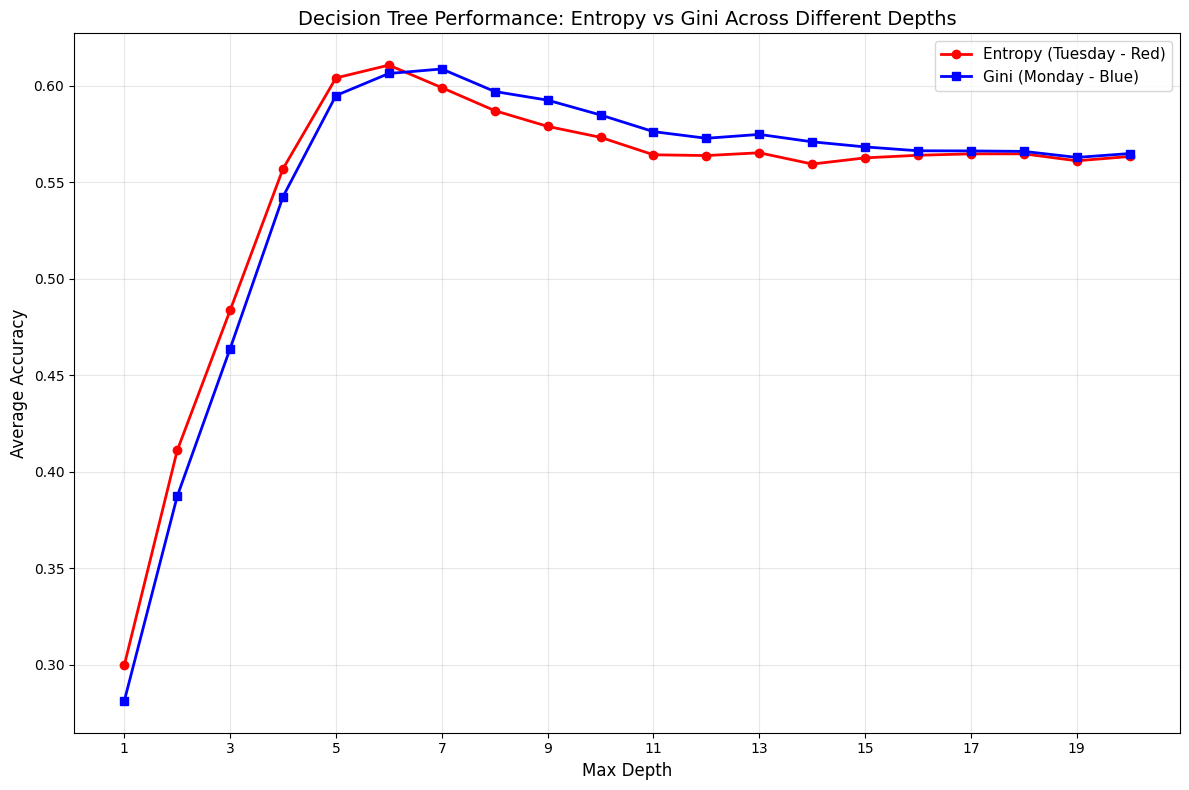


Best Models:
Entropy - Depth: 6, Accuracy: 0.6108
Gini - Depth: 7, Accuracy: 0.6088
Best Entropy model exported to: .\homework_trees/best_entropy_tree.dot
Best Gini model exported to: .\homework_trees/best_gini_tree.dot


In [4]:
# ข้อที่ 1-3
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
import matplotlib.pyplot as plt
import numpy as np
import os

# กรอกค่าของตัวเอง
current_year = 4  # ชั้นปีปัจจุบัน
num_classes = current_year + 1  # 4 + 1 = 5
num_features = num_classes * 2  # 5 * 2 = 10
n = num_classes * num_features  # 5 * 10 = 50

print(f"Current Year: {current_year}")
print(f"Number of Classes: {num_classes}")
print(f"Number of Features: {num_features}")
print(f"n (sample count): {n}")

### ห้ามแก้ไข ###
X, y = make_classification(
    n_samples=1000,
    n_features=num_features,
    n_informative=5,
    n_redundant=2,
    n_clusters_per_class=2,
    weights=[0.7, 0.2, 0.1] if num_classes == 3 else None,
    flip_y=0.1,
    n_classes=num_classes,
    random_state=42
)

class CustomDataset():
    def __init__(self, data, target, feature_names, target_names):
        self.data = data
        self.target = target
        self.feature_names = feature_names
        self.target_names = target_names

experiment_dataset = CustomDataset(X, y,
    [chr(i + ord('A')) for i in range(num_features)],
    [str(i) for i in range(num_classes)])

print(f"Dataset created with shape: {X.shape}")
print(f"Target classes: {np.unique(y)}")

### ส่วนที่ต้องแก้ไขเพื่อที่จะได้ผลลัพท์ตามข้อที่ 2 - 3 ###
def compareAvgAccuracy(dataset, seed_range, depth_range):
    acc_entropy = []
    acc_gini = []

    best_entropy_acc = 0
    best_gini_acc = 0
    best_entropy_model = None
    best_gini_model = None
    best_entropy_depth = 0
    best_gini_depth = 0

    print("Training models across different depths...")
    
    for depth in range(depth_range[0], depth_range[1]):
        total_entropy_acc = 0.0
        total_gini_acc = 0.0
        
        for seed in range(seed_range[0], seed_range[1]):
            X_train, X_test, y_train, y_test = train_test_split(
                dataset.data, dataset.target, test_size=0.25, random_state=seed)

            # entropy
            model_entropy = DecisionTreeClassifier(max_depth=depth, criterion='entropy')
            model_entropy.fit(X_train, y_train)
            y_pred_entropy = model_entropy.predict(X_test)
            acc_entropy_seed = accuracy_score(y_test, y_pred_entropy)
            total_entropy_acc += acc_entropy_seed

            # gini
            model_gini = DecisionTreeClassifier(max_depth=depth, criterion='gini')
            model_gini.fit(X_train, y_train)
            y_pred_gini = model_gini.predict(X_test)
            acc_gini_seed = accuracy_score(y_test, y_pred_gini)
            total_gini_acc += acc_gini_seed

        # คำนวนค่า acc เฉลี่ยของแต่ละ seed
        avg_entropy_acc = total_entropy_acc / (seed_range[1] - seed_range[0])
        avg_gini_acc = total_gini_acc / (seed_range[1] - seed_range[0])
        
        acc_entropy.append(avg_entropy_acc)
        acc_gini.append(avg_gini_acc)
        
        # เก็บ model ที่ดีที่สุด
        if avg_entropy_acc > best_entropy_acc:
            best_entropy_acc = avg_entropy_acc
            best_entropy_depth = depth
            # Train best model with seed 0
            X_train, X_test, y_train, y_test = train_test_split(
                dataset.data, dataset.target, test_size=0.25, random_state=0)
            best_entropy_model = DecisionTreeClassifier(max_depth=depth, criterion='entropy')
            best_entropy_model.fit(X_train, y_train)
            
        if avg_gini_acc > best_gini_acc:
            best_gini_acc = avg_gini_acc
            best_gini_depth = depth
            # Train best model with seed 0
            X_train, X_test, y_train, y_test = train_test_split(
                dataset.data, dataset.target, test_size=0.25, random_state=0)
            best_gini_model = DecisionTreeClassifier(max_depth=depth, criterion='gini')
            best_gini_model.fit(X_train, y_train)

        print(f"Depth {depth}: Entropy={avg_entropy_acc:.4f}, Gini={avg_gini_acc:.4f}")

    # วาดกราฟ accuracy
    plt.figure(figsize=(12, 8))
    
    # สีตามวันที่ submit (สมมุติ submit วันอังคาร)
    # วันอังคาร = สีแดง, วันจันทร์ (เมื่อวาน) = สีน้ำเงิน
    plt.plot(range(depth_range[0], depth_range[1]), acc_entropy, 
             label="Entropy (Tuesday - Red)", color="red", marker="o", linewidth=2)
    plt.plot(range(depth_range[0], depth_range[1]), acc_gini, 
             label="Gini (Monday - Blue)", color="blue", marker="s", linewidth=2)
    
    plt.xlabel('Max Depth', fontsize=12)
    plt.ylabel('Average Accuracy', fontsize=12)
    plt.title('Decision Tree Performance: Entropy vs Gini Across Different Depths', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(depth_range[0], depth_range[1], 2))
    plt.tight_layout()
    plt.show()

    # สร้าง export_graphviz สำหรับ model ที่ดีที่สุด
    PROJECT_ROOT_DIR = "."
    IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "homework_trees")
    os.makedirs(IMAGES_PATH, exist_ok=True)

    print(f"\nBest Models:")
    print(f"Entropy - Depth: {best_entropy_depth}, Accuracy: {best_entropy_acc:.4f}")
    print(f"Gini - Depth: {best_gini_depth}, Accuracy: {best_gini_acc:.4f}")

    # Export best entropy model
    if best_entropy_model is not None:
        export_graphviz(
            best_entropy_model,
            out_file=os.path.join(IMAGES_PATH, "best_entropy_tree.dot"),
            feature_names=dataset.feature_names,
            class_names=dataset.target_names,
            rounded=True,
            filled=True
        )
        print(f"Best Entropy model exported to: {IMAGES_PATH}/best_entropy_tree.dot")

    # Export best gini model  
    if best_gini_model is not None:
        export_graphviz(
            best_gini_model,
            out_file=os.path.join(IMAGES_PATH, "best_gini_tree.dot"),
            feature_names=dataset.feature_names,
            class_names=dataset.target_names,
            rounded=True,
            filled=True
        )
        print(f"Best Gini model exported to: {IMAGES_PATH}/best_gini_tree.dot")
    
    return {
        'best_entropy_depth': best_entropy_depth,
        'best_entropy_acc': best_entropy_acc,
        'best_gini_depth': best_gini_depth,
        'best_gini_acc': best_gini_acc,
        'entropy_accs': acc_entropy,
        'gini_accs': acc_gini
    }

# รัน experiment
results = compareAvgAccuracy(experiment_dataset, seed_range=(0, n), depth_range=(1, 21))

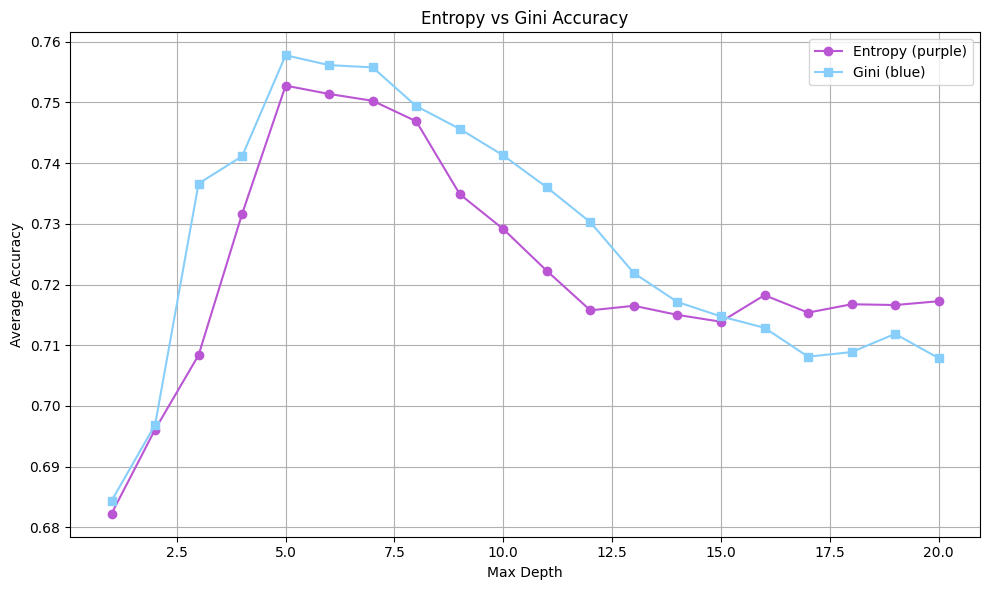

ตัวอย่างการตอบในข้อที่ 4 (ใช้กราฟจากข้อที่ 2)
ตอบ :
จากกราฟที่เราได้เห็นขอตอบว่า Max_depth ที่ 5 และ Criterion เป็น Gini ก็เพราะว่า ที่ Max_depth 5 เนี่ย เส้นสีฟ้าของเรามันพุ่งขึ้นไปสูงสุดเลย สูงจนแทบจะทะลุเพดานโลก นั่นหมายความว่าโมเดลของเรามันฉลาดเป็นกรดเลยครับพี่น้อง มันสามารถจับโกหกพวกแก๊งคอลเซ็นเตอร์ได้แบบเส้นผมบังภูเขาเลยทีเดียว

ANS:

จากกราฟจะเห็นได้ว่า Max_depth ที่ 6 และ Criterion เป็น Entrophy เพราะว่าที่ Max_depth 6 นั้นมี Accuracy ที่สูงที่สุดจากทั้ง 2 Model จึงเหมาะที่สุดในการปราบแก๊งคอลเซ็นเตอร์